In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

In [5]:
def load_model_results(file_name, N=-1):
    file = np.load(file_name)
    if N<0:
        predictions = file["predictions"][:, :]
    else:
        predictions = file["predictions"][:, :N]

    targets = file["targets"][:, 0]

    return predictions, targets

def load_ensemble_predictions(dtype, data_path, N, trim=True):
    model1_file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint32_dropout0.1_FConly_N40/dropout_{dtype}_uncertainty_32.npz"
    model2_file = f"seed2_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint29_dropout0.1_FConly_N40/dropout_{dtype}_uncertainty_32.npz"
    model3_file = f"seed3_128_0.0005_5e-3_0.0002_75_25_20/eval_checkpoint34_dropout0.1_FConly_N40/dropout_{dtype}_uncertainty_32.npz"

    model1_preds, model1_targets = load_model_results(model1_file, N=N)
    model2_preds, model2_targets = load_model_results(model2_file, N=N)
    model3_preds, model3_targets = load_model_results(model3_file, N=N)
    print(model1_preds.shape)
    # Join all predictions
    ensemble_predictions = np.concatenate([model1_preds, model2_preds, model3_preds], axis=1)
    print(ensemble_predictions.shape)
    
    if trim:
        print("trimming predictions")
        q1, q3  = np.percentile(ensemble_predictions, [25, 75], axis=1)
        iqr = q3 - q1
        if1 = q1 - 1.5*iqr
        if3 = q3 + 1.5*iqr
        ensemble_stds = np.zeros(ensemble_predictions.shape[0])
        ensemble_medians = np.zeros(ensemble_predictions.shape[0])
        for i in range(len(ensemble_predictions)):
            trimmed = ensemble_predictions[i][np.where(np.logical_and(ensemble_predictions[i] > if1[i], 
                                                                      ensemble_predictions[i] < if3[i]))]
            ensemble_stds[i] = np.std(trimmed)
            ensemble_medians[i] = np.median(trimmed)
    else:
        ensemble_medians = np.median(ensemble_predictions, axis=1)
        ensemble_stds = np.std(ensemble_predictions, axis=1)
        
    # Ensure targets are the same for all three models
    assert np.array_equal(model1_targets, model2_targets)
    assert np.array_equal(model1_targets, model3_targets)
    # Calculate residual stats (actual-predicted)
    #pick_residuals = model1_targets - ensemble_means
    pick_residuals = model1_targets - ensemble_medians
    residual_mean = np.mean(pick_residuals)
    residual_std = np.std(pick_residuals)

    # Combine into a dataframe
    #df_data = {"y_pred":ensemble_means, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}
    df_data = {"y_pred":ensemble_medians, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}

    df = pd.DataFrame(data=df_data)
    df.head()

    # read in meta_df
    if dtype=="test":
        dtype="test_fewerhist"
    meta_df = pd.read_csv(f"{data_path}/uuss_{dtype}.csv")

    return df, meta_df

In [6]:
N=40
val_df, val_meta_df = load_ensemble_predictions("validation", "../uuss_data/p_resampled", N)
test_df, test_meta_df = load_ensemble_predictions("test_fewerhist", "../uuss_data/p_resampled", N)

(37476, 40)
(37476, 120)
trimming predictions
(79906, 40)
(79906, 120)
trimming predictions


In [7]:
print("Validation df lengths:", len(val_df), len(val_meta_df))
print("Test df lengths:", len(test_df), len(test_meta_df))
print("Shared evids between datasets?:", np.any(np.isin(test_meta_df.evid.unique(), val_meta_df.evid.unique())))

Validation df lengths: 37476 37476
Test df lengths: 79906 79906
Shared evids between datasets?: False


# Accurate Uncertainties for Deep Learning Using Calibrated Regression
Recalibration dataset $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$
1. Compute $F_t$ = CDF[$N(\mu_t, \sigma^2_t)]$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. compute $\hat{P}(p)=\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$, where $p=F_t(y_t)$ for t $\in$ [1, T]

Fit Isotonic Regression model R to D

- Fitting regression model to D' = $\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ seems easier for adjusting the "standard deviation" to be calibrated.
- When using D, will need to compute the CDF of the Gaussian with predicted $\mu$ and $\sigma$, transform with R, and then invert for $x_{lb}$ and $x_{ub}$. Since the CDF has been transformed, norm.ppf can no longer be used to invert. 
- When using D', can compute the ppf of the gaussian with predicted $\mu$ and $\sigma$ and evaluate it at R(lb) and R(ub). 
- I show below that $x_{lb}$ and $x_{ub}$ computed using the D' method intersect with the transformed CDF computed using D at 0.16 and 0.84. 

## Fit Predicted vs Empirical Curve $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$ with Isotonic Regression

In [8]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())
eval_cdf(val_df)

     y_pred       std  y_act  residual       cdf
0  0.315696  0.026230   0.32  0.004304  0.565174
1  0.144053  0.020237   0.20  0.055947  0.997151
2  0.408807  0.026066   0.43  0.021193  0.791903
3  0.375705  0.073054   0.45  0.074295  0.845421
4  0.243182  0.024261   0.18 -0.063182  0.004603


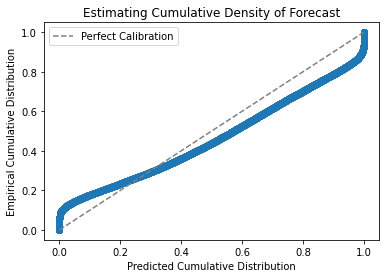

In [9]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution")
        plt.xlabel("Predicted Cumulative Distribution")
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution")
        plt.ylabel("Predicted Cumulative Distribution")
    plt.title("Estimating Cumulative Density of Forecast")
    plt.legend();
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    plot_empirical_cdf(df, swap_xy)
compute_empirical_cdf(val_df)

In [10]:
def check_nondecreasing(df):
    assert ~np.any(np.diff(df.sort_values("cdf")["p_hat"].values) < 0), "CDF vs P_Hat is not non-decreasing"
    assert ~np.any(np.diff(df.sort_values("p_hat")["cdf"].values) < 0), "P_Hat vs CDF is not non-decreasing"
    
check_nondecreasing(val_df)

In [11]:
def plot_calibration_curve(df, regressor, title, swap_xy=False):
    p_hat_cal = []
    p_hat_uncal = []
    T = len(df)
    for p in np.arange(0, 1.05, 0.05):
        if swap_xy:
            p_hat_cal.append((df.cdf <= regressor.predict([p])[0]).sum()/T)
        else:
            p_hat_cal.append((regressor.predict(df.cdf) <= p).sum()/T)
        
        p_hat_uncal.append((df["cdf"] <= p).sum()/T)

    plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, marker="o", label="uncalibrated")
    plt.legend()
    plt.title(title)

## Fit Empirical vs Predicted Curve $D=\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ with Isotonic Regression

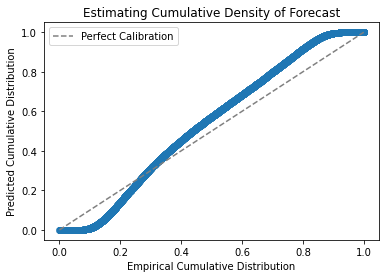

In [12]:
# Inner fence median
plot_empirical_cdf(val_df, swap_xy=True)

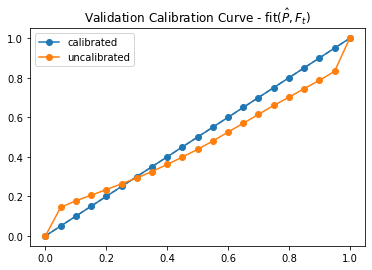

In [13]:
# Fit isotonic regression model to Empirical vs Predicted curve. 
iso_reg_inv = IsotonicRegression().fit(val_df.p_hat.values, val_df.cdf.values)
plot_calibration_curve(val_df, iso_reg_inv, r"Validation Calibration Curve - fit$(\hat{P}, F_t)$", swap_xy=True)

     y_pred       std  y_act  residual       cdf
0  0.287414  0.019478   0.32  0.032586  0.952827
1  0.197265  0.017643   0.20  0.002735  0.561606
2  0.416185  0.023756   0.43  0.013815  0.719562
3  0.462235  0.033849   0.45 -0.012235  0.358879
4  0.140625  0.020745   0.18  0.039375  0.971153


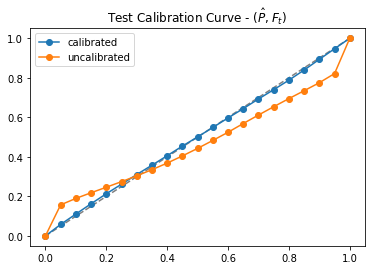

In [14]:
eval_cdf(test_df)
plot_calibration_curve(test_df, iso_reg_inv, r"Test Calibration Curve - $(\hat{P}, F_t)$", swap_xy=True)

# Go with Isotonic Regression of $D = \{(\hat{P}(F_t(y_t)), F_t(y_t))\}_{t=1}^T$...
(Empirical vs Predicted) because it is easier to adjust the X bounds to truly contain 68% of the data. The other ways is better for identifying what percent of data are truly within the original 68% bounds (e.g. 68% -> 39%). 

In [15]:
lb = 0.16
ub = 0.84

# Transform the lower and upper bounds to be calibrated
lb_transform = iso_reg_inv.transform([lb])[0]
ub_transform = iso_reg_inv.transform([ub])[0]

# Compute the lower and upper bounds for each prediction given the mean and std
test_df["lb_y"] = test_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
test_df["ub_y"] = test_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

test_df.head()

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
0,0.287414,0.019478,0.32,0.032586,0.952827,0.259105,0.320902
1,0.197265,0.017643,0.20,0.002735,0.561606,0.171622,0.227597
2,0.416185,0.023756,0.43,0.013815,0.719562,0.381659,0.457027
3,0.462235,0.033849,0.45,-0.012235,0.358879,0.413039,0.520429
4,0.140625,0.020745,0.18,0.039375,0.971153,0.110474,0.176291


In [16]:
# Compute the lower and upper bounds for each prediction given the mean and std
val_df["lb_y"] = val_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
val_df["ub_y"] = val_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

val_df.head()

,y_pred,std,y_act,residual,cdf,p_hat,lb_y,ub_y
0,0.315696,0.026230,0.32,0.004304,0.565174,0.494183,0.277574,0.360790
1,0.144053,0.020237,0.20,0.055947,0.997151,0.909862,0.114641,0.178844
2,0.408807,0.026066,0.43,0.021193,0.791903,0.694204,0.370923,0.453621
3,0.375705,0.073054,0.45,0.074295,0.845421,0.740901,0.269529,0.501302
4,0.243182,0.024261,0.18,-0.063182,0.004603,0.090938,0.207922,0.284892


### Within the calibrated intervals

In [17]:
# Fraction of true picks that are within the calibrated lower and upper bounds 
((test_df["y_act"] > test_df["lb_y"]) & (test_df["y_act"] < test_df["ub_y"])).sum()/len(test_df)

0.6554826921632919

In [18]:
((val_df["y_act"] > val_df["lb_y"]) & (val_df["y_act"] < val_df["ub_y"])).sum()/len(val_df)

0.6799818550539012

### Within 1 std (uncalibrated)

In [19]:
((test_df["y_act"] > (test_df["y_pred"]-test_df["std"])) & (test_df["y_act"] < (test_df["y_pred"]+test_df["std"]))).sum()/len(test_df)

0.5037919555477687

In [20]:
((val_df["y_act"] > (val_df["y_pred"]-val_df["std"])) & (val_df["y_act"] < (val_df["y_pred"]+val_df["std"]))).sum()/len(val_df)

0.526790479240047

In [21]:
from joblib import dump
dump(iso_reg_inv, 'p_dropout_calibration_model_medians_ensemble_IFtrimmed_N40_DR0.1.joblib') 

['p_dropout_calibration_model_medians_ensemble_IFtrimmed_N40_DR0.1.joblib']